In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.patches as patches
from matplotlib import cm

In [3]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)
ORDER = [0, 2, 3, 1]
version = 'v7_IRLS'

# Panel a

In [4]:
res_corsi = loadmat(f'../../all_corsi_log_{version}.mat')['all_corsi'][0]

res_2back = loadmat(f'../../all_2back_log_{version}.mat')['all_2back'][0]

res_rtime = loadmat(f'../../all_rtime_log_{version}.mat')['all_r_time']

res_switch = loadmat(f'../../all_switch_log_{version}.mat')['all_switch']

res_sRT = res_rtime[0]
res_cRT = res_rtime[1]
res_global = res_switch[0]
res_local = res_switch[1]


Simple reaction time = 0.023
Choice reaction time = 0.348
Task switch global = 0.070
Task switch local = 0.017
Corsi = 0.133
2-back = 0.012


,f-value,R2,beta,test,N,p-value
0,4.067945,0.022935,0.564302,Simple reaction time,179,4.521563e-02
1,95.183119,0.348436,3.490883,Choice reaction time,180,0.000000e+00
2,8.631747,0.069912,0.001175,Task switch global,117,3.992414e-03
3,1.925308,0.016656,-0.000448,Task switch local,117,1.679555e-01
4,26.447025,0.133453,-0.025004,Corsi,175,7.277214e-07
5,1.299678,0.011696,-0.014917,2-back,128,2.564346e-01


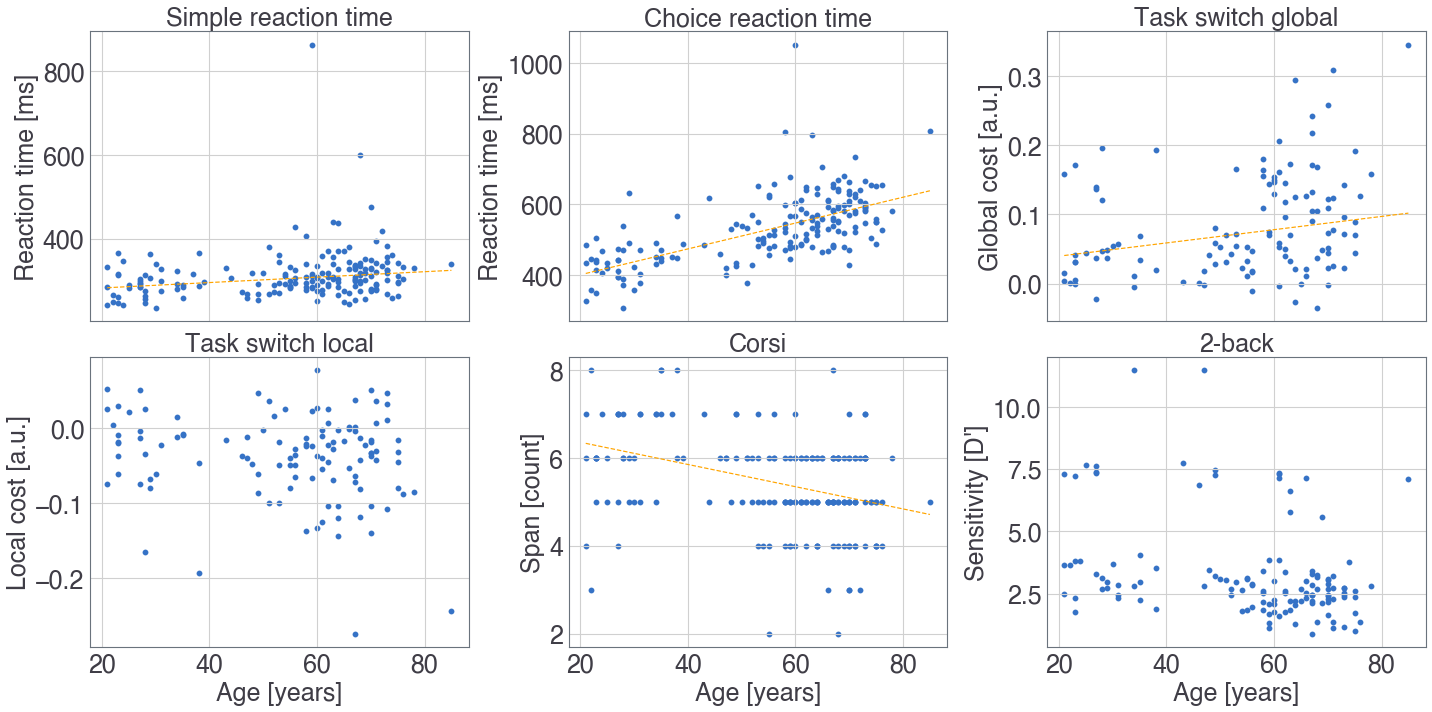

In [15]:
TITLES = ['Simple reaction time', 'Choice reaction time', 'Task switch global', 'Task switch local', 'Corsi', "2-back"] 
VALUES = [res_sRT, res_cRT, res_global, res_local, res_corsi, res_2back]
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=True)

df_fig4pana = pd.DataFrame(columns={'test', 'N', 'R2', 'p-value', 'f-value', 'beta'})

for IDX in range(6):

    age = VALUES[IDX][0].flat[0][3]
    gender = VALUES[IDX][0].flat[0][4]
    data_it = VALUES[IDX][0].flat[0][2].flat[0]
    gender_k = data_it[4].flat[0][3]

    k = data_it[3].flat[0][3]
    r2 = data_it[3].flat[0][0]
    fval = data_it[3].flat[0][1]
    p = data_it[3].flat[0][2]
    
    gender_corrected_res = data_it[2]
    print(f"{TITLES[IDX]} = {r2[0][0]:.3f}")
    _min = np.argmin(age)
    _max = np.argmax(age)
    
    ax[IDX // 3][IDX % 3].scatter(age, gender_corrected_res + gender * gender_k[0] + gender_k[1])
    if p[0][0] < 0.05:
        ax[IDX // 3][IDX % 3].plot([age[_min], age[_max]], np.array([age[_min], age[_max]]) * k[0] + k[1] + np.array([gender[_min], gender[_max]]) * gender_k[0] + gender_k[1], '--', color='orange')
    ax[IDX // 3][IDX % 3].set_title(TITLES[IDX])
    
    _ylim = ax[IDX // 3][IDX % 3].get_ylim()[1]
    df_fig4pana = df_fig4pana.append({'test': TITLES[IDX], 'N': len(age), 
                                      'R2': r2[0][0], 'p-value': p[0][0], 
                                      'f-value': fval[0][0], 'beta':k[0][0]}, ignore_index=True)
#     ax[IDX // 3][IDX % 3].text(20,  _ylim * 0.7, f"R2 = {r2[0][0]:.2f} \np-val = {p[0][0]:.2e}", fontsize=20)

ax[0][0].set_ylabel('Reaction time [ms]')
ax[0][1].set_ylabel('Reaction time [ms]')
ax[0][2].set_ylabel('Global cost [a.u.]')
ax[1][0].set_ylabel('Local cost [a.u.]')
ax[1][1].set_ylabel('Span [count]')
ax[1][2].set_ylabel("Sensitivity [D']")

ax[1][0].set_xlabel("Age [years]")
ax[1][1].set_xlabel("Age [years]")
ax[1][2].set_xlabel("Age [years]")
plt.tight_layout()
plt.savefig('figure_4_panel_a.pdf')
df_fig4pana.to_csv(f'figure_4_panel_a.csv', index=False)
df_fig4pana

# Extra plot

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 12), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):
    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]


    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

    data_it = all_age_res[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[0][i].imshow(np.sign(masks_uni[0]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    

    im = ax[1][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                            interpolation='none', norm=Normalize(0, vmax=vmax_r * 0.99))
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(r'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .2))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0][0].text(-12, 51, 't-value', size=22)    
ax[1][0].text(-8, 51, r'$R^2$', size=22)    
plt.tight_layout()
plt.savefig('figure_1_panel_c.pdf', transparent=True)

# Panel b

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True, sharex=True)
VALUES = [res_cRT, res_global, res_corsi]
IDX = 1
for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

    # val for age
    val = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    mdl = val[2]
    r2_full = np.zeros(2500)
    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
    print(np.max(r2_full))
    im = ax[i].imshow(r2_full.reshape(50, 50).T)
    plt.colorbar(im, ax=ax[i])
    ax[i].invert_yaxis()
    
plt.tight_layout()

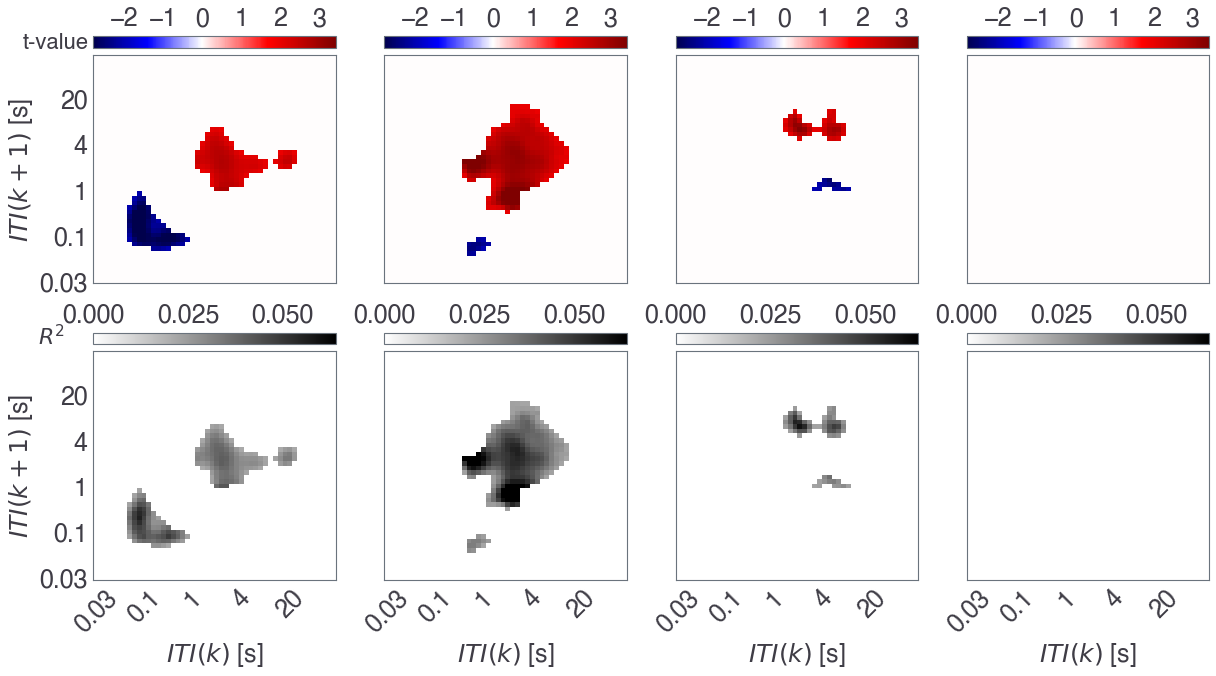

In [13]:
TITLES = ['cRT', 'switchGlobal', 'corsi'] 
VALUES = [res_cRT, res_global, res_corsi]
fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 0 # 0 == cRT // 2 == switchGlobal

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):

#     data_it = res_cRT[i].flat[0][1].flat[0]
    data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
    mask = data_it[5].reshape(50, 50).T
    p_vals = data_it[6].reshape(50, 50).T
    f_vals = data_it[7].reshape(50, 50).T
    r_vals = data_it[8].reshape(50, 50).T
    r2_vals = data_it[9].reshape(50, 50).T
    k = data_it[10][:, 0].reshape(50, 50).T

    f_vals[f_vals < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(f_vals) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(f_vals) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_vals, 99))
    vmin_r = min(vmin_r, np.percentile(r2_vals, 1))

th_R2 = 0.1

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

    # val for age
    val = VALUES[IDX][ORDER[i]].flat[0][1].flat[0]
    mdl = val[2]
    r2_full = np.zeros(2500)
    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
    mask_age_r2 = r2_full.reshape(50, 50).T > th_R2
    
    data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
    mask = data_it[5].reshape(50, 50).T
    p_vals = data_it[6].reshape(50, 50).T
    f_vals = data_it[7].reshape(50, 50).T
    r_vals = data_it[8].reshape(50, 50).T
    r2_vals = data_it[9].reshape(50, 50).T
    k = data_it[10][:, 0].reshape(50, 50).T

    f_vals[f_vals < 0] = 0
    
    im = ax[0][i].imshow(mask_age_r2 * np.sign(mask) * np.sqrt(f_vals) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=vmin_f, vmax=vmax_f))
#     im = ax[0][i].imshow(np.sign(masks_uni[IDX]) * np.sqrt(square_f) * np.sign(k), aspect='auto', cmap='seismic', interpolation='none')

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    
    # R2
#     r2_vals[r2_vals < 1e-5] = 0
    
    im = ax[1][i].imshow(mask_age_r2 * np.sign(mask) * r2_vals, aspect='auto', cmap='binary',
                         interpolation='none', norm=Normalize(0, vmax_r))
#                          interpolation='none', norm=TwoSlopeNorm(0, vmin=-0.01, vmax=vmax_r))
    
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel(f'$ITI(k)$ [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .1))
    
ax[0][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[1][0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0][0].text(-15, 51, 't-value', size=22)    
ax[1][0].text(-12, 51, r'$R^2$', size=22)    
plt.savefig(f'figure_4_panel_b_{TITLES[IDX]}.pdf', transparent=True)

# 

<ipython-input-14-0c0510667273>:21: UserWarning: No contour levels were found within the data range.
  im = ax[i].contour(Z * np.sign(mask), [2], colors=CMAPS[IDX], alpha=.75, norm=norm, linewidths=5)


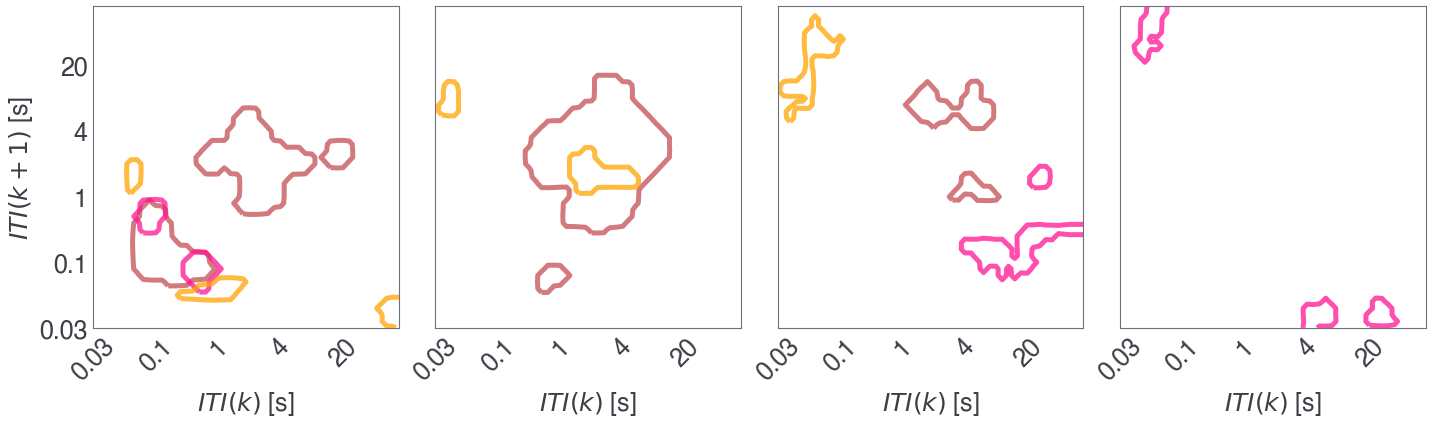

In [14]:
VALUES = [res_cRT, res_global, res_corsi]
CMAPS = ['r', 'deeppink', 'orange']
TITLES = ['Complex reaction time', 'Global cost on task switch',  'Corsi span'] 
fig, ax = plt.subplots(1, 4, figsize=(20, 6), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):
    for IDX in range(3):
        data_it = VALUES[IDX][ORDER[i]].flat[0][2].flat[0]
        mask = data_it[5].reshape(50, 50).T
        p_vals = data_it[6].reshape(50, 50).T
        f_vals = data_it[7].reshape(50, 50).T
        r_vals = data_it[8].reshape(50, 50).T
        r2_vals = data_it[9].reshape(50, 50).T
        k = data_it[10][:, 0].reshape(50, 50).T
        f_vals[f_vals < 0] = 0
        Z = f_vals
        norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
        im = ax[i].contour(Z * np.sign(mask), [2], colors=CMAPS[IDX], alpha=.75, norm=norm, linewidths=5)
        
        ax[i].plot([0], [0], color=CMAPS[IDX], label=TITLES[IDX], linewidth=5)
        ax[i].set_xticks(ticks)
        ax[i].set_xticklabels(labels)
        ax[i].xaxis.set_tick_params(rotation=45)
        ax[i].set_yticks(ticks)
        ax[i].set_yticklabels(labels)
        ax[i].set_xlabel(r'$ITI(k)$ [s]')
        ax[i].grid(False)
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]')
plt.tight_layout()
# ax[3].legend(loc='upper center', shadow=True, fancybox=True, ncol=2, bbox_to_anchor=[0, 0.5])
plt.savefig('figure_4_panel_c_no_legend.pdf', transparent=True)